# Time series analysis and forecast

In [1]:
''' Source code from time series analysis and forecast - Follow up from Medium's post. '''


__author__ = "Gabriel de Lima Duarte"
__maintainer__ = "Gabriel de Lima Duarte"
__email__ = "gabriellimadduarte@gmail.com"


import pandas as pd
import datetime
import numpy as np
import math
import matplotlib.pylab as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from math import sqrt

def stat_test(series_value):
    ''' Tiny function to check series stationarity'''
    
    #Let's check if the series is stationary:
    stat_test = adfuller(series_value)
    test_result = pd.Series(stat_test[0:4], index = ['Test statistics', 'p-value', 'Lags Used', 'Number of used observations'])

    print(test_result)


In [2]:
df = pd.read_csv('AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'], infer_datetime_format = True)

# is it stationary? 
stat_test(df['#Passengers'])

Test statistics                  0.815369
p-value                          0.991880
Lags Used                       13.000000
Number of used observations    130.000000
dtype: float64


## Dealing with non-stationary series 
Checking multiple techniques, let's bring this bad boy to the stationary side

In [3]:
# Log function
log_series = pd.Series(np.log(df['#Passengers'].values), index = df['Month'])
stat_test(log_series.values)

Test statistics                 -1.717017
p-value                          0.422367
Lags Used                       13.000000
Number of used observations    130.000000
dtype: float64


In [4]:
# Removing the rolling mean
moving_average = df['#Passengers'].rolling(window = 12).mean()
df_no_average = df['#Passengers'].shift(periods = 11) - moving_average
no_mean_series = pd.Series(df_no_average.values, index = df['Month'])
no_mean_series.dropna(inplace = True)
stat_test(no_mean_series)

Test statistics                 -3.648235
p-value                          0.004903
Lags Used                       13.000000
Number of used observations    119.000000
dtype: float64


In [5]:
# Differentiating
diff_series = pd.Series(df['#Passengers'].diff().values, index = df['Month'])
diff_series.dropna(inplace = True)
stat_test(diff_series)

Test statistics                 -2.829267
p-value                          0.054213
Lags Used                       12.000000
Number of used observations    130.000000
dtype: float64


In [6]:
# Applying both options:
log_moving_average = log_series.rolling(window = 12).mean()
log_no_average = log_series.shift(periods = 11) - log_moving_average
log_no_mean_series = pd.Series(log_no_average.values, index = df['Month'])
log_no_mean_series.dropna(inplace = True)
stat_test(log_no_mean_series)

Test statistics                 -3.128477
p-value                          0.024516
Lags Used                       13.000000
Number of used observations    119.000000
dtype: float64


Clearly, the best option regarding this dataset is to remove the rolling average and predict with it.


# ARIMA - Choosing parameters

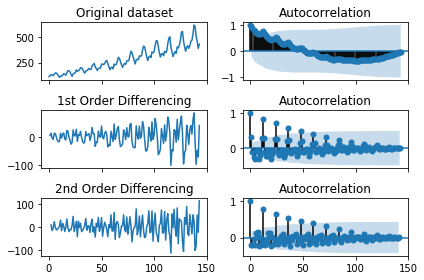

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Original data set plot
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df['#Passengers']); axes[0, 0].set_title('Original dataset')
plot_acf(df['#Passengers'], ax=axes[0, 1])

# First order differencing
axes[1, 0].plot(df['#Passengers'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df['#Passengers'].diff().dropna(), ax=axes[1, 1])

# Second order differencing
axes[2, 0].plot(df['#Passengers'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df['#Passengers'].diff().diff().dropna(), ax=axes[2, 1])

plt.savefig('ACF_differencing_plots')
plt.tight_layout()
plt.show()

In [8]:
first_diff = df['#Passengers'].diff() # Differencing the first order
first_diff.dropna(inplace = True) # Removing problems
stat_test(first_diff)

Test statistics                 -2.829267
p-value                          0.054213
Lags Used                       12.000000
Number of used observations    130.000000
dtype: float64


In [9]:
second_diff = first_diff.diff() # Differencing the second order
second_diff.dropna(inplace = True) # Removing problems
stat_test(second_diff)

Test statistics               -1.638423e+01
p-value                        2.732892e-29
Lags Used                      1.100000e+01
Number of used observations    1.300000e+02
dtype: float64


So, both order are stationary. No need to go further.

## Let's find p and q:

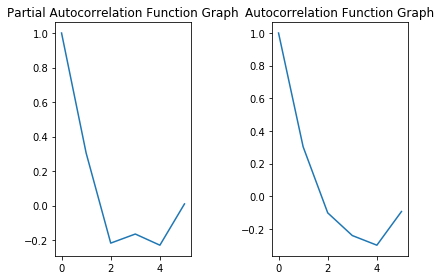

In [10]:
from statsmodels.graphics.tsaplots import acf, pacf

lets_find_p = pacf(first_diff, nlags=5) # Limited the lags for better visualization
lets_find_q = acf(first_diff, nlags=5) 

# Plotting
plt.subplot(121)
plt.plot(lets_find_p)
plt.title('Partial Autocorrelation Function Graph')

plt.subplot(122)
plt.plot(lets_find_q)
plt.title('Autocorrelation Function Graph')
plt.tight_layout()


Let's form a model with both orders:
 - (2,1,2) for the differentiated series
 - (2,0,2) for the series without the moving average

### Order = (2,0,2)

/home/gabriel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


22.71038358213415


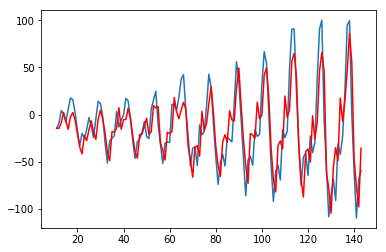

In [11]:
# (2,0,2)
from statsmodels.tsa.arima_model import ARIMA 

df_no_average.dropna(inplace=True) # Using the version without the rolling average

arima_model = ARIMA(df_no_average, order = (2,0,2))
arima_fit = arima_model.fit(disp = -1) # No convergence is outputted

shifted_df = df_no_average#.shift(periods=0) # The shifting concerns the differentiation order.
shifted_df.dropna(inplace = True)

rmse = sqrt(mean_squared_error(arima_fit.fittedvalues, shifted_df.values)) # error

plt.plot(df_no_average)
plt.plot(arima_fit.fittedvalues, color = 'red') # plotting the fit
print(rmse)

In [12]:
fc, se, conf = arima_fit.forecast(12, alpha = 0.2) #forecasting 1 year, alpha is the confidence interval

last_date = pd.to_datetime(df['Month'].tail(1).values)
forecast_index = []
for i in range(len(fc)): # generating the forecast's index
    next_date = last_date + pd.DateOffset(months = 1)
    forecast_index.append(next_date[0])
    last_date = next_date

forecast_series = pd.Series(fc, index = forecast_index)
forecast_series

1961-01-01   -28.665788
1961-02-01     2.800326
1961-03-01    22.408655
1961-04-01    27.420754
1961-05-01    19.757358
1961-06-01     4.411148
1961-07-01   -12.630781
1961-08-01   -26.268833
1961-09-01   -33.500812
1961-10-01   -33.777325
1961-11-01   -28.597986
1961-12-01   -20.632177
dtype: float64

Now, we have predicted one year of passengers. But the results are a little weird. That's because it's without the rolling average. We need to adjust it. 
So, the behaviour is almost linear. With this is mind, let's find a function that fits our behaviour and find the rolling average for the forecast!

In [13]:
from scipy.optimize import curve_fit 

def linear_function(x, a, b): 
    return a + x*b 

moving_average.dropna(inplace = True)
moving_average.reset_index(drop = True, inplace = True)
param, param_cov = curve_fit(linear_function, moving_average.index, moving_average.values) 

def moving_average_function(x):
    return param[0] + param[1]*x

In [14]:
df_no_average_series = pd.Series(df_no_average.values, index = df['Month'][11:])
concat_series = pd.concat([df_no_average_series, forecast_series])
index_ = np.linspace(0,len(concat_series)-1, len(concat_series))

moving_average_forecast = moving_average_function(index_) # this is the moving average
whole_series = pd.Series(concat_series.values+moving_average_forecast, index = concat_series.index)

How well does the function perform compared to the real data?


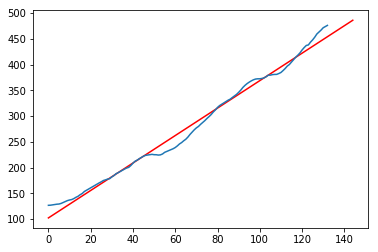

In [15]:
plt.plot(moving_average_forecast, color = 'red')
plt.plot(moving_average.values)
# even though there're some considerable errors, it tends to balance themselves. 

Let's predict using a more visual approach:

/home/gabriel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/gabriel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


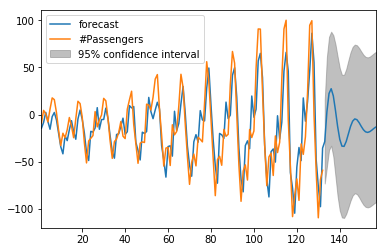

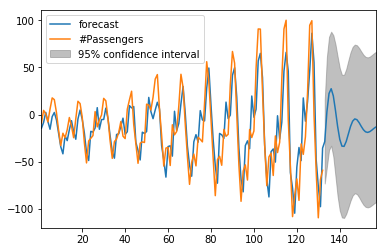

In [16]:
arima_fit.plot_predict(1,157) # predicting one year

### Order = (2,1,2)

25.05756928425486


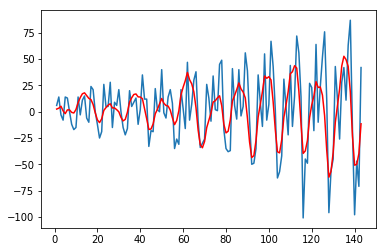

In [17]:
# (2,1,2)
from statsmodels.tsa.arima_model import ARIMA 

arima_model = ARIMA(df['#Passengers'], order = (2,1,2))
arima_fit = arima_model.fit(disp = -1) # No convergence is outputted

shifted_df = df['#Passengers'].diff()#.shift(periods=1) # The shifting concerns the differentiation order.
shifted_df.dropna(inplace = True)

rmse = sqrt(mean_squared_error(arima_fit.fittedvalues, shifted_df.values)) # error

plt.plot(df['#Passengers'].diff()) # the differentiated data once d is 1.
plt.plot(arima_fit.fittedvalues, color = 'red') # plotting the fit
print(rmse)

In [18]:
fc, se, conf = arima_fit.forecast(12, alpha = 0.2) #forecasting 1 year, alpha is the confidence interval

last_date = pd.to_datetime(df['Month'].tail(1).values)
forecast_index = []
for i in range(len(fc)): # generating the forecast's index
    next_date = last_date + pd.DateOffset(months = 1)
    forecast_index.append(next_date[0])
    last_date = next_date

forecast_series = pd.Series(fc, index = forecast_index)
forecast_series

1961-01-01    433.118834
1961-02-01    450.888104
1961-03-01    479.811742
1961-04-01    511.972826
1961-05-01    539.324585
1961-06-01    555.807809
1961-07-01    558.756312
1961-08-01    549.287189
1961-09-01    531.665708
1961-10-01    511.903957
1961-11-01    496.029358
1961-12-01    488.506042
dtype: float64

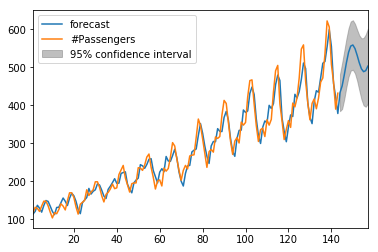

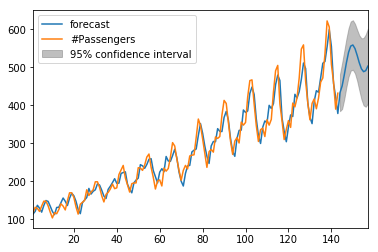

In [19]:
arima_fit.plot_predict(1,157) # predicting one year